In [8]:
import numpy as np
import time
import pygame
from io import StringIO
from contextlib import closing
import os
from typing import Optional

import gymnasium as gym
from gymnasium import spaces, Env
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure

import matplotlib.pyplot as plt
import tensorboard

In [2]:
# Set up TensorBoard logging
log_dir = "./logs/"
new_logger = configure(log_dir, ["stdout", "tensorboard"])

Logging to ./logs/


In [217]:
# Define the map
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| :C| : : |",
    "| : : : : |",
    "| | : | :M|",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)
FRAME_RATE = 10  # Frames per second

class MultiAgentTaxiEnv(Env):
    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": FRAME_RATE,
    }

    def __init__(self, render_mode=None, num_agents=2, num_tasks=3):
        super(MultiAgentTaxiEnv, self).__init__()
        self.desc = np.asarray(MAP, dtype="c")
        self.num_agents = num_agents
        self.num_tasks = num_tasks

        # Define the possible locations and their colors
        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (1, 5)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]

        # Define some predefined sequences
        self.predefined_sequences = [
            [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4)], # Sequence 1
            [(0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (0, 0)], # Sequence 2
            [(4, 0), (4, 3), (1, 2), (3, 4), (0, 0), (0, 4)], # Sequence 3
            [(4, 3), (1, 2), (3, 4), (0, 0), (0, 4), (4, 0)], # Sequence 4
        ]

        # Define no-spawn areas (colored blocks and walls)
        self.no_spawn_areas = set(self.locs)

        # Action space: 6 actions for each agent (move in 4 directions, pick up, drop off)
        self.action_space = spaces.MultiDiscrete([6] * self.num_agents)
        # Observation space: Positions and statuses of agents and tasks
        self.observation_space = spaces.Box(
            low=0, high=5, shape=(self.num_agents * 4 + self.num_tasks * 4,), dtype=np.int32
        )

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        np.random.seed(seed)

        while True:  # Loop until a valid configuration is found
            # Initialize agents' positions and task states
            self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)  # x, y, occupancy status
            
            # Exclude no-spawn areas for taxi spawning
            possible_taxi_spawns = [(x, y) for x in range(5) for y in range(5) if (x, y) not in self.no_spawn_areas]

            if len(possible_taxi_spawns) < self.num_agents:
                raise ValueError("Not enough available locations to place all taxis.")
            
            self.agents[:, :2] = np.array([possible_taxi_spawns.pop(np.random.randint(0, len(possible_taxi_spawns))) for _ in range(self.num_agents)])

            self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)

            # Choose a predefined sequence
            chosen_sequence = self.predefined_sequences[np.random.randint(len(self.predefined_sequences))]
            pickup_locs = chosen_sequence[:self.num_tasks]
            dropoff_locs = chosen_sequence[self.num_tasks:self.num_tasks*2]

            for i in range(self.num_tasks):
                self.tasks[i] = np.array([pickup_locs[i][0], pickup_locs[i][1], dropoff_locs[i][0], dropoff_locs[i][1]])

            # Validate that no taxis are on colored blocks and all tasks are spawned
            valid_configuration = True
            for agent in self.agents:
                if (agent[0], agent[1]) in self.no_spawn_areas:
                    valid_configuration = False
                    break
            
            if valid_configuration and len(self.tasks) == self.num_tasks:
                break

        return self._get_obs(), {}

    def _get_obs(self):
        # Added distance to the nearest task for each agent
        distances = []
        for agent in self.agents:
            distances.append(min([abs(agent[0] - task[0]) + abs(agent[1] - task[1]) for task in self.tasks]))

        return np.concatenate([self.agents.flatten(), self.tasks.flatten(), np.array(distances)])

    def step(self, actions):
        assert self.action_space.contains(actions), f"Invalid action: {actions}"

        rewards = np.zeros(self.num_agents)
        terminated = False
        truncated = False

        for i in range(self.num_agents):
            if actions[i] == 0:  # Move up
                self.agents[i, 1] = max(self.agents[i, 1] - 1, 0)
            elif actions[i] == 1:  # Move down
                self.agents[i, 1] = min(self.agents[i, 1] + 1, 4)
            elif actions[i] == 2:  # Move left
                self.agents[i, 0] = max(self.agents[i, 0] - 1, 0)
            elif actions[i] == 3:  # Move right
                self.agents[i, 0] = min(self.agents[i, 0] + 1, 4)
            elif actions[i] == 4:  # Pick up task
                for task_id, task in enumerate(self.tasks):
                    if np.array_equal(self.agents[i, :2], task[:2]) and self.agents[i, 2] == 0:
                        self.agents[i, 2] = task_id + 1  # Carry task_id + 1
                        rewards[i] += 10  # Reward for successful pickup
                        break  # Stop checking other tasks once one is picked up
            elif actions[i] == 5:  # Drop off task
                task_id = self.agents[i, 2] - 1
                if task_id >= 0 and np.array_equal(self.agents[i, :2], self.tasks[task_id, 2:]):
                    rewards[i] += 20  # Reward for successful drop-off
                    self.tasks[task_id] = np.array([-1, -1, -1, -1])  # Invalidate the task
                    self.agents[i, 2] = 0  # No longer carrying task
                else:
                    rewards[i] -= 10  # Penalty for illegal drop-off

            # Penalize for each step to encourage efficiency
            rewards[i] -= 1

        # Check if all tasks are completed
        if all(self.tasks[:, 0] == -1):
            terminated = True

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), np.sum(rewards), terminated, truncated, {}

    def render(self, mode='rgb_array'):
        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[toy-text]"`'
            ) from e

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Multi-Agent Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert self.window is not None, "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if self.taxi_imgs is None:
            file_names = [
                "img/cab_front.png",
                "img/cab_rear.png",
                "img/cab_right.png",
                "img/cab_left.png",
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = "img/passenger.png"
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = "img/hotel.png"
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                "img/gridworld_median_left.png",
                "img/gridworld_median_horiz.png",
                "img/gridworld_median_right.png",
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                "img/gridworld_median_top.png",
                "img/gridworld_median_vert.png",
                "img/gridworld_median_bottom.png",
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = "img/taxi_background.png"
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)
                elif desc[y][x] == b"M":
                    color_cell = pygame.Surface(self.cell_size)
                    color_cell.set_alpha(128)
                    color_cell.fill((255, 0, 255))
                    self.window.blit(color_cell, cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for agent in self.agents:
            self.window.blit(self.taxi_imgs[0], self.get_surf_loc((agent[0], agent[1])))

        for task in self.tasks:
            if task[0] != -1:
                self.window.blit(self.passenger_img, self.get_surf_loc((task[0], task[1])))
                self.window.blit(self.destination_img, self.get_surf_loc((task[2], task[3])))

        if self.render_mode == "rgb_array":
            return pygame.surfarray.array3d(self.window)

        pygame.display.flip()

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (map_loc[0] + 1) * self.cell_size[1]

    def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()

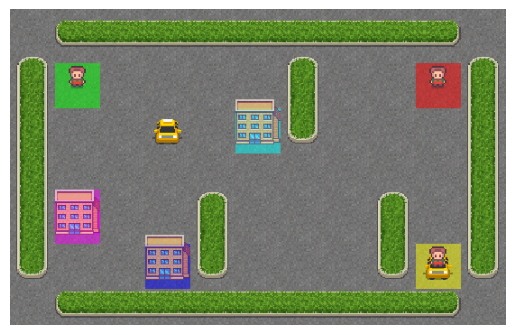

In [218]:
# Initialize the environment
base_env = MultiAgentTaxiEnv(render_mode="rgb_array", num_agents=2, num_tasks=3)

# Check if the environment follows the Gymnasium API
check_env(base_env, warn=True)

# Reset the environment
obs, info = base_env.reset()

# Run one step to capture the frame
actions = base_env.action_space.sample()  # Take a random action
obs, reward, terminated, truncated, info = base_env.step(actions)

# Capture the frame
frame = base_env.render(mode="rgb_array")

# Display the frame using matplotlib
frame = np.rot90(frame, k=3)
plt.imshow(frame)
plt.axis('off')  # Hide the axes
plt.show()

In [7]:
# initialize the environment
base_env = MultiAgentTaxiEnv(render_mode="rgb_array", num_agents=2, num_tasks=3)

# Check if the environment follows the Gymnasium API
check_env(base_env, warn=True)

In [28]:
# env = DummyVecEnv([lambda: Monitor(MultiAgentTaxiEnv(render_mode="human", num_agents=2, num_tasks=3))])

# # create the model
# model = PPO('MlpPolicy', env, verbose=1)
# model.set_logger(new_logger)

# # Setup evaluation callback
# eval_env = DummyVecEnv([lambda: Monitor(MultiAgentTaxiEnv(render_mode="human", num_agents=2, num_tasks=3))])
# eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
#                              log_path='./logs/', eval_freq=500,
#                              deterministic=True, render=False)

# # train the model
# model.learn(total_timesteps=10000, callback=eval_callback)

# # save the model
# model.save("ppo_multi_agent_taxi")

# # load the model
# model = PPO.load("ppo_multi_agent_taxi")

In [4]:
# Initialize and check the base environment
base_env = MultiAgentTaxiEnv(render_mode="human", num_agents=2, num_tasks=3)
check_env(base_env, warn=True)

# Initialize the custom environment and wrap it with Monitor and DummyVecEnv
env = DummyVecEnv([lambda: Monitor(MultiAgentTaxiEnv(render_mode="human", num_agents=2, num_tasks=3))])


In [6]:
# Set up TensorBoard logging
log_dir = "./logs/"
new_logger = configure(log_dir, ["stdout", "tensorboard"])

# PPO model parameters
total_timesteps = 1338900

# Create the PPO model and set the logger
model = PPO('MlpPolicy', env, verbose=1,
            batch_size=64,
            ent_coef=0.1,
            gamma=0.985,
            learning_rate=0.003,
            n_steps=2048,
            n_epochs=10,
            policy_kwargs=dict(net_arch=[dict(pi=[64, 64], vf=[64, 64])]))

model.set_logger(new_logger)

# Train the model
model.learn(total_timesteps=total_timesteps)

# Save the model
model.save("ppo_multi_agent_taxi")

Logging to ./logs/
Using cuda device


/home/beelzebub/.local/lib/python3.10/site-packages/stable_baselines3/common/policies.py:460: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 169  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.025538277 |
|    clip_fraction        | 0.395       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.56       |
|    explained_variance   | -0.00328    |
|    learning_rate        | 0.003       |
|    loss                 | 204         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0405     |
|    value_loss           | 2.6e+03     |
-----------------------------------------
----------------------------------

KeyboardInterrupt: 

In [5]:
# Load the trained model
model = PPO.load("ppo_multi_agent_taxi")

# test the model
obs = env.reset()
done = False

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(DELAY)  # Control the speed of the simulation

env.close()

KeyboardInterrupt: 

In [9]:
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| :C| : :M|",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)
FRAME_RATE = 10  # Frames per second
DELAY = 0.1  # Delay in seconds

class MultiAgentTaxiEnv(Env):
    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": FRAME_RATE,
    }

    def __init__(self, render_mode=None, num_agents=2, num_tasks=3):
        super(MultiAgentTaxiEnv, self).__init__()
        self.desc = np.asarray(MAP, dtype="c")
        self.num_agents = num_agents
        self.num_tasks = num_tasks

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (1, 5)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]

        self.action_space = spaces.MultiDiscrete([6] * self.num_agents)
        self.observation_space = spaces.Box(
            low=0, high=5, shape=(self.num_agents * 3 + self.num_tasks * 4,), dtype=np.int32
        )

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)
        self.agents[:, :2] = np.random.randint(0, 5, (self.num_agents, 2))

        self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)
        for i in range(self.num_tasks):
            pickup_loc = self.locs[np.random.randint(0, len(self.locs))]
            dropoff_loc = self.locs[np.random.randint(0, len(self.locs))]
            while dropoff_loc == pickup_loc:
                dropoff_loc = self.locs[np.random.randint(0, len(self.locs))]
            self.tasks[i] = np.array([pickup_loc[0], pickup_loc[1], dropoff_loc[0], dropoff_loc[1]])

        return self._get_obs(), {}

    def _get_obs(self):
        return np.concatenate([self.agents.flatten(), self.tasks.flatten()])

    def step(self, actions):
        assert self.action_space.contains(actions), f"Invalid action: {actions}"

        rewards = np.zeros(self.num_agents)
        terminated = False
        truncated = False

        for i in range(self.num_agents):
            if actions[i] == 0:  # Move up
                self.agents[i, 1] = max(self.agents[i, 1] - 1, 0)
            elif actions[i] == 1:  # Move down
                self.agents[i, 1] = min(self.agents[i, 1] + 1, 4)
            elif actions[i] == 2:  # Move left
                self.agents[i, 0] = max(self.agents[i, 0] - 1, 0)
            elif actions[i] == 3:  # Move right
                self.agents[i, 0] = min(self.agents[i, 0] + 1, 4)
            elif actions[i] == 4:  # Pick up task
                for task_id, task in enumerate(self.tasks):
                    if np.array_equal(self.agents[i, :2], task[:2]) and self.agents[i, 2] == 0:
                        self.agents[i, 2] = task_id + 1  # Carry task_id + 1
                        rewards[i] += 10  # Reward for successful pickup
                        break  # Stop checking other tasks once one is picked up
            elif actions[i] == 5:  # Drop off task
                task_id = self.agents[i, 2] - 1
                if task_id >= 0 and np.array_equal(self.agents[i, :2], self.tasks[task_id, 2:]):
                    rewards[i] += 20  # Reward for successful drop-off
                    self.tasks[task_id] = np.array([-1, -1, -1, -1])  # Invalidate the task
                    self.agents[i, 2] = 0  # No longer carrying task
                else:
                    rewards[i] -= 10  # Penalty for illegal drop-off

            # Penalize for each step to encourage efficiency
            rewards[i] -= 1

        # Check if all tasks are completed
        if all(self.tasks[:, 0] == -1):
            terminated = True

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), np.sum(rewards), terminated, truncated, {}

    def render(self, mode='human'):
        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[toy-text]"`'
            ) from e

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Multi-Agent Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert (
            self.window is not None
        ), "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                "img/cab_front.png",
                "img/cab_rear.png",
                "img/cab_right.png",
                "img/cab_left.png",
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = "img/passenger.png"
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = "img/hotel.png"
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                "img/gridworld_median_left.png",
                "img/gridworld_median_horiz.png",
                "img/gridworld_median_right.png",
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                "img/gridworld_median_top.png",
                "img/gridworld_median_vert.png",
                "img/gridworld_median_bottom.png",
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = "img/taxi_background.png"
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for agent in self.agents:
            self.window.blit(self.taxi_imgs[0], self.get_surf_loc((agent[0], agent[1])))

        for task in self.tasks:
            if task[0] != -1:
                self.window.blit(self.passenger_img, self.get_surf_loc((task[0], task[1])))
                self.window.blit(self.destination_img, self.get_surf_loc((task[2], task[3])))

        pygame.display.flip()

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()

    def _compute_transition_and_rewards(self):
        num_states = self.observation_space.shape[0]
        num_actions_per_agent = self.action_space.nvec[0]
        num_actions = num_actions_per_agent ** self.num_agents

        P = np.zeros((num_actions, num_states, num_states))
        R = np.zeros((num_states, num_actions))

        # Iterate over all states and actions
        for state in range(num_states):
            for action in range(num_actions):
                # Decompose the multi-agent action into individual agent actions
                individual_actions = np.unravel_index(action, [num_actions_per_agent] * self.num_agents)
                
                # Simulate the environment with the given state and action
                self.reset()
                self.state = state
                
                # Handle different return values of step method
                result = self.step(individual_actions)
                if len(result) == 3:
                    next_state, reward, done = result
                elif len(result) == 4:
                    next_state, reward, done, _ = result
                else:
                    next_state, reward, done, truncated, _ = result
                
                P[action, state, next_state] += 1
                R[state, action] = reward

        # Normalize the transition matrix
        for action in range(num_actions):
            P[action] /= P[action].sum(axis=1, keepdims=True)
        
        return P, R

In [13]:
import mdptoolbox

# Initialize the environment
env = MultiAgentTaxiEnv()

# Compute transition and reward matrices
P, R = env._compute_transition_and_rewards()

# Define discount factor
discount_factor = 0.9

# Initialize Policy Iteration
pi = mdptoolbox.mdp.PolicyIteration(P, R, discount_factor)

# Run Policy Iteration
pi.run()

# Print the optimal policy and value function
print(f"Optimal Policy: {pi.policy}")
print(f"Value Function: {pi.V}")

Optimal Policy: (4, 24, 10, 0, 6, 9, 3, 28, 28, 28, 4, 7, 1, 28, 1, 10, 1, 4)
Value Function: (47.284824163058445, 47.0281972753195, 47.028197275319506, 37.0281972753195, 38.45390220720249, 38.45390220720249, 38.45390220720249, 38.45390220720249, 47.284824163058445, 46.29158306051329, 47.028197275319506, 37.284824163058445, 37.028197275319506, 46.29158306051329, 37.284824163058445, 47.284824163058445, 38.45390220720249, 46.29158306051329)


In [23]:
def test_policy(env, policy, num_episodes=10, max_steps=1000):
    for episode in range(num_episodes):
        print("Episode:", episode + 1)
        obs, _ = env.reset()
        done = False
        total_reward = 0
        step = 0  # Initialize step counter
        while not done and step < max_steps:
            if not isinstance(obs, (tuple, list)):
                obs = (obs,)
            if len(obs) != len(env.observation_space.shape):
                raise ValueError("obs dimensions do not match env.observation_space.shape")
            try:
                state_index = np.ravel_multi_index(obs, env.observation_space.shape)[0]
                action_index = policy[int(state_index)]
                actions = np.unravel_index(action_index, env.action_space.nvec)
                obs, reward, done, _, _ = env.step(actions)
                total_reward += reward
                step += 1  # Increment step counter
            except ValueError as e:
                print(f"Error: {e}")
                break
        if step >= max_steps:
            print("Reached maximum steps without finishing episode.")
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

test_policy(env, pi.policy, num_episodes=10)

Episode: 1
Reached maximum steps without finishing episode.
Episode 1: Total Reward: -1990.0
Episode: 2
Reached maximum steps without finishing episode.
Episode 2: Total Reward: -2000.0
Episode: 3
Reached maximum steps without finishing episode.
Episode 3: Total Reward: -2000.0
Episode: 4
Reached maximum steps without finishing episode.
Episode 4: Total Reward: -2000.0
Episode: 5
Reached maximum steps without finishing episode.
Episode 5: Total Reward: -2000.0
Episode: 6
Reached maximum steps without finishing episode.
Episode 6: Total Reward: -2000.0
Episode: 7
Reached maximum steps without finishing episode.
Episode 7: Total Reward: -2000.0
Episode: 8
Reached maximum steps without finishing episode.
Episode 8: Total Reward: -2000.0
Episode: 9
Reached maximum steps without finishing episode.
Episode 9: Total Reward: -2000.0
Episode: 10
Reached maximum steps without finishing episode.
Episode 10: Total Reward: -2000.0
